# Proyecto final KDD

**Docente: Andrés Castillo**

## Introdución

La estimación de los precios de la vivienda es esencial tanto para los propietarios como para los inversores, ya que ambos necesitan entender el valor de este activo inmobiliario. 
Para muchas personas, comprar una propiedad es una de las decisiones y compra más importantes en la vida. Además de la asequibilidad de una vivienda, otros factores, 
como la conveniencia del lugar y las perspectivas de inversión a largo plazo, también afectan
el proceso de toma de decisiones.
El mercado inmobiliario está expuesto a muchas fluctuaciones en los precios debido a las correlaciones existentes con muchas variables, algunas de las cuales no se pueden controlar
o incluso pueden ser desconocidas. Los precios de las viviendas pueden aumentar rápidamente (o en algunos casos, también bajan muy rápido).
Algunas aplicaciones para un banco son:
- Originación: Establecer el valor comercial del inmueble a financiar utilizado para la aprobación final.
- Retanqueo: Actualizar el valor comercial de garantía ya existente para aprobación de nuevos cupos de crédito.
- Monitoreo portafolio garantías: Valoración del portafolio de las garantías para cumplimiento normativo y para el análisis de riesgos del colateral.
- Normalización de cartera: Evaluar los préstamos existentes, evaluar los acuerdos de refinanciamiento Y daciones en pago.

## Objetivo:

El objetivo de este proyecto es que el estudiante aplique los temas vistos en la clase de Descubrimiento de Conocimiento para resolver un problema del mundo real, con datos reales. Lea cuidadosamente las instrucciones contenidas en el archivo "descripcion_prueba.pdf". Allí están los detalles iniciales de la prueba. Para este curso, se evaluará adicionalmente el desarrollo de los puntos de este notebook. 

Para resolver este problema, usted debe seguir las instrucciones especificas que se dan en cada parte del notebook. Al final, usted debe entregar una copia de este notebook junto con unas conclusiones finales que usted debe sacar y que deben estar contenidas al final del documento.

Cómo es usual, para empezar, debemos importar todas las librerías que vamos a necesitar. Asegurese de instalar la librería XGBoost para su sistema operativo y todas las demás, hasta que no encuentre ningún error al correr la siguiente celda:

In [2]:
# import the necessary packages

import pandas as pd
import numpy as np
import argparse
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_rows', 500)


Ahora definimos la funciones que nos ayudarán a evaluar el desempeño de nuestro modelo. Justo las mismas que se usaron en nuestro último ejercicio:

In [3]:
# Calcula el mean_absolute_percentage_error. El vector y_true no puede tener 0
def mape(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotScatterModel(aX, aY, bX, bY, model):
    paY = model.predict(aX)
    pbY = model.predict(bX)
    #Print the score on the train data
    print('R2')
    print({'Training': model.score(trainXX, trainY), 'Test': model.score(testXX, testY) })

    print('\nMAPE')
    print({'Training ': mape(trainY, paY), 'Test': mape(testY, pbY)})

    # declarando un objeto tipo Figura para desarrollar los subplots
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(1,2,1)
    plt.scatter(aY, paY, s = 0.1)
    plt.title('Correlation in training set')


    ax2 = fig.add_subplot(1,2,2)
    plt.scatter(bY, pbY, s = 0.1)
    plt.title('Correlation in test set')

Junto con este notebook, usted encontrará un conjunto de archivos con los datos de datos de entranamiento. 

# Cargar los datos que usaremos

Como es un conjunto de datos pequeño podemos cargar todo en memoría y trabajar de esta manera. Solo usaremos los archivos entrenamiento_precios_vivienda.csv  y prueba_precios_vivienda.csv. Note que los datos del archivo prueba_precios_vivienda.csv no contienen la columna de los precios de la vivienda. La idea de este archivo, es que usted complete dicha columna con los predicciones resultantes de su modelo, y mediante un proceso de validación externo, la compañia calcula el desempeño de este. Esta es una práctica muy común en pruebas de este tipo.

In [4]:
#dataTrain = pd.read_excel('data/entrenamiento_precios_vivienda.xlsx')
#dataTest = pd.read_excel('data/testeo_precios_vivienda.xlsx')
low_memory=False
dataTrain = pd.read_csv('data/entrenamiento_precios_vivienda.csv', dtype=str)
dataTest = pd.read_csv('data/prueba_precios_vivienda.csv', dtype=str)

In [5]:
# Asignar el campo id como índice del dataframe
dataTrain['id'] = pd.to_numeric(dataTrain['id'], errors='coerce')
dataTest['id'] = pd.to_numeric(dataTest['id'], errors='coerce')

dataTrain = dataTrain.set_index('id')
dataTest =  dataTest.set_index('id')
#dataTrain = dataTrain.drop(['id'], axis = 1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

dataTrain.head()

,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,sector,direccion_inmueble_informe,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,estrato,barrio_legal,topografia_sector,condiciones_salubridad,transporte,demanda_interes,paradero,alumbrado,arborizacion,alamedas,ciclo_rutas,nivel_equipamiento_comercial,descripcion_general_sector,perspectivas_de_valorizacion,actualidad_edificadora,comportamiento_oferta_demanda,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,telefono_en_el_predio,tipo_inmueble,descripcion_tipo_inmueble,uso_actual,descripcion_uso_inmueble,clase_inmueble,descripcion_clase_inmueble,ocupante,sometido_a_propiedad_horizontal,altura_permitida,observaciones_altura_permitida,aislamiento_posterior,observaciones_aislamiento_posterior,aislamiento_lateral,observaciones_aislamiento_lateral,antejardin,observaciones_antejardin,indice_ocupacion,observaciones_indice_ocupacion,indice_construccion,observaciones_indice_construccion,predio_subdividido_fisicamente,unidades,contadores_agua,contadores_luz,accesorios,area_valorada,observaciones_generales_inmueble,condicion_ph,numero_piso,numero_de_edificios,area_actividad,uso_principal_ph,rph,porteria,citofono,bicicletero,piscina,tanque_de_agua,club_house,garaje_visitantes,teatrino,sauna,vigilancia_privada,tipo_vigilancia,administracion,vetustez,pisos_bodega,estructura,ajustes_sismoresistentes,cubierta,fachada,tipo_fachada,estructura_reforzada,danos_previos,material_de_construccion,detalle_material,iluminacion,ventilacion,irregularidad_planta,irregularidad_altura,observaciones_estructura,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,observaciones_dependencias,estado_acabados_pisos,calidad_acabados_pisos,estado_acabados_muros,calidad_acabados_muros,estado_acabados_techos,calidad_acabados_techos,estado_acabados_madera,calidad_acabados_madera,estado_acabados_metal,calidad_acabados_metal,estado_acabados_banos,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,numero_total_de_garajes,total_cupos_parquedaro,numero_garaje_1,matricula_garaje_1,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,numero_garaje_2,matricula_garaje_2,garaje_cubierto_2,garaje_doble_2,garaje_paralelo_2,garaje_servidumbre_2,numero_garaje_3,matricula_garaje_3,garaje_cubierto_3,garaje_doble_3,garaje_paralelo_3,garaje_servidumbre_3,numero_garaje_4,matricula_garaje_4,garaje_cubierto_4,garaje_doble_4,garaje_paralelo_4,garaje_servidumbre_4,numero_garaje_5,matricula_garaje_5,garaje_cubierto_5,garaje_doble_5,garaje_paralelo_5,garaje_servidumbre_5,tipo_deposito,numero_total_depositos,numero_deposito_1,matricula_inmobiliaria_deposito_1,numero_deposito_2,matricula_inmobiliaria_deposito_2,numero_deposito_3,matricula_inmobiliaria_deposito_3,numero_deposito_4,matricula_inmobiliaria_deposito_4,numero_deposito_5,matricula_inmobiliaria_deposito_5,observaciones_generales_construccion,metodo_valuacion_1,concepto_del_metodo_1,metodo_valuacion_2,concepto_del_metodo_2,metodo_valuacion_3,concepto_del_metodo_3,metodo_valuacion_4,concepto_del_metodo_4,metodo_valuacion_5,concepto_del_metodo_5,metodo_valuacion_6,concepto_del_metodo_6,metodo_valuacion_7,concepto_del_metodo_7,metodo_valuacion_8,concepto_del_metodo_8,metodo_valuacion_9,concepto_del_metodo_9,area_privada,valor_area_privada,area_garaje,valor_area_garaje,area_deposito,valor_area_deposito,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# Removemos todos los caracteres especiales y pasar todas las cadenas a mayúsculas


In [9]:
import re

def stringCleanUpInPlace(dataX):
    attributes = dataX.columns

    for attribute in attributes:
        if type(dataX[attribute].values[0]) == str:
            dataX[[attribute]] = dataX[[attribute]].fillna('');
            dataX[attribute] = [re.sub('[^A-Za-z0-9.,+\-]+', '', row + '').upper() for row in dataX[attribute]]
    
    return dataX

            
stringCleanUpInPlace(dataTrain)
stringCleanUpInPlace(dataTest)

## Remove varias filas del conjunto de entranamiento que tienen las columnas del texto libre mal acotadas. Esto pasa
## pero al final la fila tiene el mismo número de columnas que las otras, entonces no se cual es realmente el avaluo.
## para evitar otros problemas, por ahora lo mejor es borrarlas
print(dataTrain.shape)
dataTrain = dataTrain[dataTrain['alcantarillado_en_el_predio'].str.len() < 3]
dataTrain = dataTrain[dataTrain['numero_piso'].str.len() < 3]
dataTrain = dataTrain[dataTrain['habitaciones'].str.len() < 3]
dataTrain = dataTrain[dataTrain['estado_acabados_pisos'].str.len() < 15]
dataTrain = dataTrain[dataTrain['metodo_valuacion_1'].str.len() < 20]
dataTrain = dataTrain[dataTrain['estrato'].str.len() < 2]


data = dataTrain.copy()

print(dataTrain.shape)

(9525, 220)
(9525, 220)


In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
dataTrain = data.copy()
#dataTrain = dataTrain[dataTrain['estrato'].str.len() < 2]
#print(dataTrain.shape)
dataTrain.head(20)

,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,sector,direccion_inmueble_informe,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,estrato,barrio_legal,topografia_sector,condiciones_salubridad,transporte,demanda_interes,paradero,alumbrado,arborizacion,alamedas,ciclo_rutas,nivel_equipamiento_comercial,descripcion_general_sector,perspectivas_de_valorizacion,actualidad_edificadora,comportamiento_oferta_demanda,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,telefono_en_el_predio,tipo_inmueble,descripcion_tipo_inmueble,uso_actual,descripcion_uso_inmueble,clase_inmueble,descripcion_clase_inmueble,ocupante,sometido_a_propiedad_horizontal,altura_permitida,observaciones_altura_permitida,aislamiento_posterior,observaciones_aislamiento_posterior,aislamiento_lateral,observaciones_aislamiento_lateral,antejardin,observaciones_antejardin,indice_ocupacion,observaciones_indice_ocupacion,indice_construccion,observaciones_indice_construccion,predio_subdividido_fisicamente,unidades,contadores_agua,contadores_luz,accesorios,area_valorada,observaciones_generales_inmueble,condicion_ph,numero_piso,numero_de_edificios,area_actividad,uso_principal_ph,rph,porteria,citofono,bicicletero,piscina,tanque_de_agua,club_house,garaje_visitantes,teatrino,sauna,vigilancia_privada,tipo_vigilancia,administracion,vetustez,pisos_bodega,estructura,ajustes_sismoresistentes,cubierta,fachada,tipo_fachada,estructura_reforzada,danos_previos,material_de_construccion,detalle_material,iluminacion,ventilacion,irregularidad_planta,irregularidad_altura,observaciones_estructura,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,observaciones_dependencias,estado_acabados_pisos,calidad_acabados_pisos,estado_acabados_muros,calidad_acabados_muros,estado_acabados_techos,calidad_acabados_techos,estado_acabados_madera,calidad_acabados_madera,estado_acabados_metal,calidad_acabados_metal,estado_acabados_banos,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,numero_total_de_garajes,total_cupos_parquedaro,numero_garaje_1,matricula_garaje_1,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,numero_garaje_2,matricula_garaje_2,garaje_cubierto_2,garaje_doble_2,garaje_paralelo_2,garaje_servidumbre_2,numero_garaje_3,matricula_garaje_3,garaje_cubierto_3,garaje_doble_3,garaje_paralelo_3,garaje_servidumbre_3,numero_garaje_4,matricula_garaje_4,garaje_cubierto_4,garaje_doble_4,garaje_paralelo_4,garaje_servidumbre_4,numero_garaje_5,matricula_garaje_5,garaje_cubierto_5,garaje_doble_5,garaje_paralelo_5,garaje_servidumbre_5,tipo_deposito,numero_total_depositos,numero_deposito_1,matricula_inmobiliaria_deposito_1,numero_deposito_2,matricula_inmobiliaria_deposito_2,numero_deposito_3,matricula_inmobiliaria_deposito_3,numero_deposito_4,matricula_inmobiliaria_deposito_4,numero_deposito_5,matricula_inmobiliaria_deposito_5,observaciones_generales_construccion,metodo_valuacion_1,concepto_del_metodo_1,metodo_valuacion_2,concepto_del_metodo_2,metodo_valuacion_3,concepto_del_metodo_3,metodo_valuacion_4,concepto_del_metodo_4,metodo_valuacion_5,concepto_del_metodo_5,metodo_valuacion_6,concepto_del_metodo_6,metodo_valuacion_7,concepto_del_metodo_7,metodo_valuacion_8,concepto_del_metodo_8,metodo_valuacion_9,concepto_del_metodo_9,area_privada,valor_area_privada,area_garaje,valor_area_garaje,area_deposito,valor_area_deposito,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# Clasificar los atributos según el tipo

Esta es una de las partes más importantes del proceso y es aquí donde necesitamos mas conocimiento del negocio. Me he basado en el diccionario de datos que entregaron y de la interpretación que pude hacer de los demás atributos. Como se puede ver, no he usado todas las variables. En el listado está solo la mitad de todas las diponibles.

Usualmente divido los atributos en numéricos, categóricos nominales y categóricos ordinales y texto no estructurado. Como no pienso usar los datos geoespaciales, voy a considerar por ahora la latitud y la longitud como variables numéricas.

**Tarea**

Usando la información disponible clasifique los atributos que usará para resolver el problema entre `numericColumns`, `factorColumns`, `levelColumns` y  `textColumns`

Las columnas objetivo son: `'valor_total_avaluo', 'valor_uvr', 'valor_avaluo_en_uvr'`
Aunque usaremos solo la primera realmente.

In [11]:
from pandas.api.types import CategoricalDtype

numericColumns = ['area_privada', 'area_garaje', 'area_deposito', 'area_terreno', 'area_construccion', 'area_otros', 'area_libre',
                 'observaciones_aislamiento_posterior', 
                  'observaciones_aislamiento_lateral', 'observaciones_altura_permitida', 'observaciones_antejardin',
                  'observaciones_indice_ocupacion', 'observaciones_indice_construccion',
                 'unidades', 'accesorios', 'contadores_agua', 'contadores_luz', 'area_valorada', 'numero_piso', 
                  'numero_de_edificios', 'vetustez', 'pisos_bodega', 'habitaciones', 'estar_habitacion', 'cuarto_servicio',
                 'closet', 'sala', 'comedor', 'bano_privado', 'bano_servicio', 'cocina', 'estudio', 'balcon', 'terraza',
                 'patio_interior', 'jardin', 'zona_de_ropas', 'zona_verde_privada', 'local', 'oficina', 'bodega', 
                  'numero_total_de_garajes', 'total_cupos_parquedaro', 'numero_total_depositos', 'Longitud', 'Latitud',
                 'valor_total_avaluo', 'valor_uvr', 'valor_avaluo_en_uvr']

factorColumns = ['objeto', 'sardineles_en_las_vias', 'alamedas', 'aislamiento_posterior', 'aislamiento_lateral',
                 'antejardin', 'indice_ocupacion', 'indice_construccion', 'condicion_ph',
                'rph', 'teatrino', 'tipo_credito', 'tipo_subsidio',
                 'departamento_inmueble', 'municipio_inmueble', 'sector', 'predio_subdividido_fisicamente',
                 'area_actividad', 'tipo_deposito']

levelColumns = ['demanda_interes', 'nivel_equipamiento_comercial', 'estrato']

textColumns = ['descripcion_general_sector', 'perspectivas_de_valorizacion', 'actualidad_edificadora',
               'comportamiento_oferta_demanda', 'observaciones_generales_inmueble', 'observaciones_dependencias',
              'observaciones_generales_construccion', 'metodo_valuacion_1']

target = ['valor_total_avaluo', 'valor_uvr', 'valor_avaluo_en_uvr']

def toDataTypesInPlace(dataX):
    # Convert to numeric attributes
    # Nothing to do in python. Numeric is the dafault
    realNumericColumns = []
    for col in numericColumns:
        if  col in dataX.columns:
            realNumericColumns.append(col)
            if type(dataX[col].values[0]) == str:
                dataX[col] = [re.sub(',', '.', row + '') for row in dataX[col]]
                dataX[col] = pd.to_numeric(dataX[col], errors='coerce')

    # loop to change each column to category type
    for col in factorColumns:
        if  col in dataX.columns:
            cat_type = CategoricalDtype(categories = None, ordered = False)
            dataX[col] = dataX[col].astype(dtype = cat_type)

    # Conver to levels / Ordinals
    #for col in levelColumns:
    col = 'demanda_interes'
    cat_type = CategoricalDtype(categories = [ 'NULA', 'DBIL', 'MEDIA', 'FUERTE'], ordered = True)
    dataX[col] = dataX[col].astype(dtype = cat_type)

    col = 'nivel_equipamiento_comercial'
    cat_type = CategoricalDtype(categories = [ 'REGULARMALO', 'ENPROYECTO', 'BUENO',  'MUYBUENO'], ordered = True)
    dataX[col] = dataX[col].astype(dtype = cat_type)

    col = 'estrato'
    cat_type = CategoricalDtype(categories = [ '0', '1', '2', '3', '4', '5', '6', '7'], ordered = True)
    dataX[col] = dataX[col].astype(dtype = cat_type)
    # Delete the textColumns. I dont have time to deal with it now
    #dataTrain = dataTrain.drop(textColumns, axis=1)
    print(len(dataX.columns))
    dataX = dataX[factorColumns + levelColumns + realNumericColumns]
    #dataTrain = dataTrain.drop(['barrio'], axis = 1)
    print(len(dataX.columns))
    return dataX

dataTrain = toDataTypesInPlace(dataTrain)
dataTest = toDataTypesInPlace(dataTest)

220
71
220
71


# Miremos las variables nominales

Debemos hacer algo con el departamento, el municipio y el area_actividad. Talvez solo debemos considerar los principales valores de estas variables categóricas. He utilizado la visualización durante la curación de los datos. Esto me ha permitido saber que habían errores y así pude quitar todas la filas que estaban dañadas.

**Tarea**

Muestre diagramas tipo torta para una de las variables categoricas

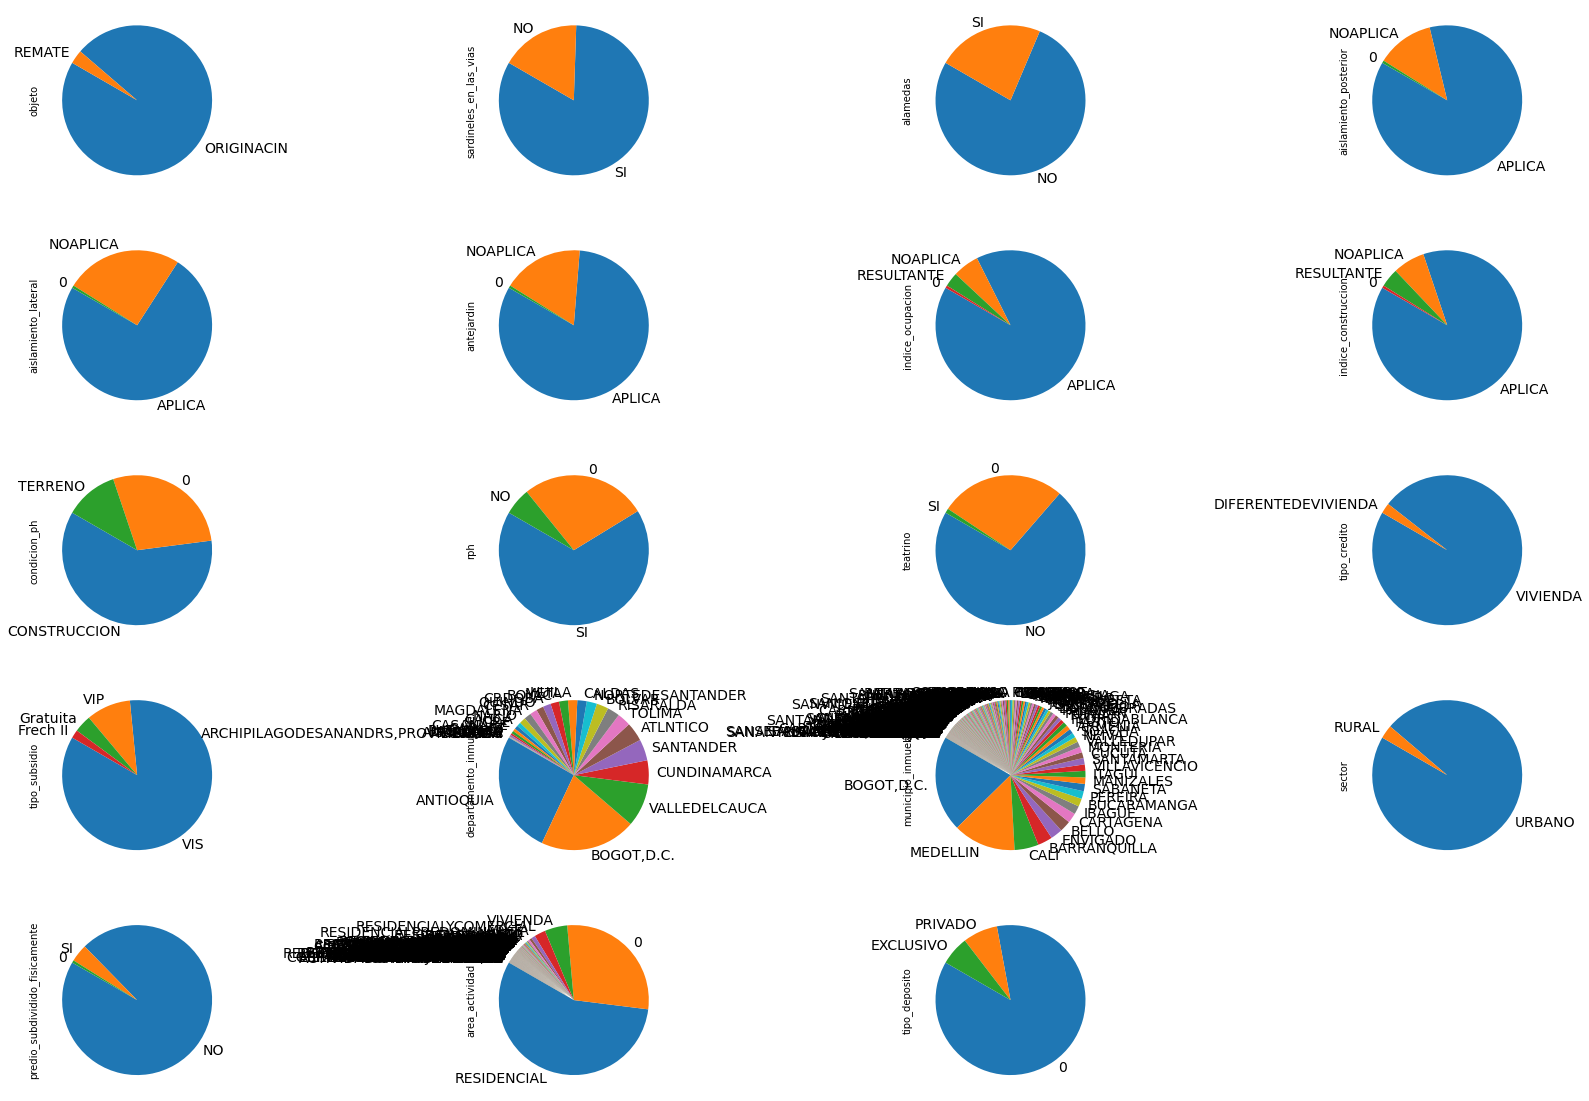

In [17]:

fig = plt.figure(figsize=(30, 20))

# Declarando las graficas de tipo Pie para Variables Categoricas
x = 1
for catAtt in factorColumns:
  ax = fig.add_subplot(5,4,x)
  dataTrain[catAtt].value_counts().plot(kind='pie', ax=ax, startangle=150, fontsize=14)
  x = x + 1

plt.show()

# Miremos las variables numéricas (solo la variable objetivo en este caso)

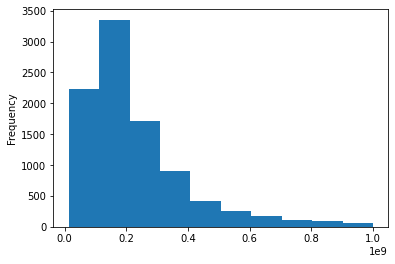

In [18]:
#dataTrain[dataTrain['valor_total_avaluo'] < 1e9]
dataTrain['valor_total_avaluo'].plot(kind='hist', rwidth=1)
plt.show()

Es claro que hay unos outlayer que harán que nuestro proceso de predicción sea dificil. Lo mejor es eliminarlos. Por ahora simplemente elimino los registros con valores por encima de 1e9. También lo mejor es eliminar los registros con avaluos muy bajos. No creo que algo en realidad valga menos de $100.000 por ejemplo 

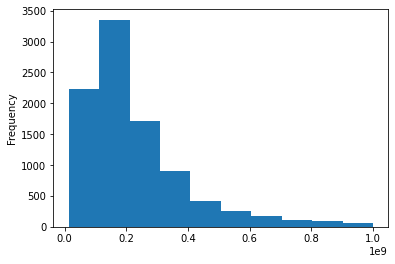

0
0


In [19]:
dataTrain[dataTrain['valor_total_avaluo'] < 1e9]['valor_total_avaluo'].plot(kind='hist', rwidth=1)
plt.show()
print(sum(dataTrain['valor_total_avaluo'] > 1e9))
print(sum(dataTrain['valor_total_avaluo'] <= 1000000))

**Tarea**

Removemos los ejemplos donde:
* dataTrain['valor_total_avaluo'] < 1e9
* dataTrain['valor_total_avaluo'] > 100000

In [20]:
#¿Hay un error en la tarea? si eliminamos los menores que 1e9 y los mayores que 100000 los graficos de las variables ordinales salen en blanco
#Pero si guardamos los menores 1e9 y los mayores que 100000 los graficos de las variables ordinales se muestran adecuadamente

dataTrain = dataTrain[dataTrain['valor_total_avaluo'] < 1e9]
dataTrain = dataTrain[dataTrain['valor_total_avaluo'] > 100000]
dataTrain.shape

dataTrain.shape

(9310, 71)

# Miremos las variables ordinales

**Tarea**

Muestre diagramas tipo torta para una de las variables ordinales

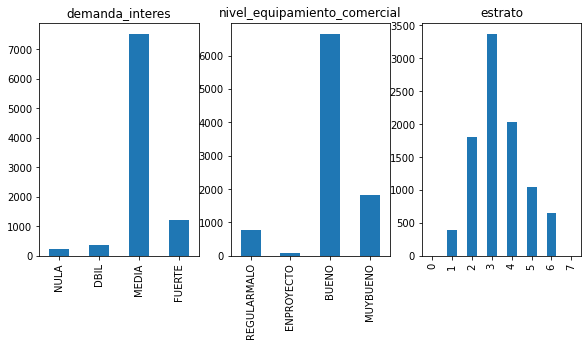

In [21]:
fig = plt.figure(figsize=(30, 60))
x = 1
for catAtt in levelColumns:
    # Completar
    ax = fig.add_subplot(6,6,x)
    dataTrain[catAtt].value_counts(sort=False).plot(kind='bar', ax=ax, figsize=(20, 30)).set_title(catAtt)
    x = x + 1
plt.show()

# Separamos los datos de entramiento 

En nuestro conjunto de entramiento, tenemos los atributos descriptivos y la variable de interés(avaluo de la vivienda) en la misma matriz. A continuación debe separar los datos en `dataX` y `dataY`

**Tarea**

Separar los datos de manera que en dataY solo tenga el atributo target[0] y en dataX todos los atributos que no hagan parte de la lista target.

In [22]:
#dataY que contiene target[0]
dataY = dataTrain[target[0]]

#Eliminamos de dataTrain el target para guardar todos los que no hacen parte de dicha lista 
dataX = dataTrain.drop(target, axis=1)

# Convertir factores a dummy y levels a numeric

Ahora debemos convertir los atributos nominales y ordinales en variables numéricas. Adicionalmente debemos eleminar los datos con valores no definidos. 

In [23]:
def dataToNumeric(dataIn, factorColumns, levelColumns):
    columns = dataIn.columns
    for catAtt in factorColumns:
        if catAtt in columns:
            dummies = pd.get_dummies(dataIn[catAtt], prefix = catAtt)
            dataIn = pd.concat([dataIn.drop(catAtt, axis = 1), dummies], axis = 1)

    for catAtt in levelColumns:
        if catAtt in columns:
            dataIn[catAtt] = dataIn[catAtt].cat.codes
    
    return dataIn


# Fill NAN in numerical attributes
def fillNaNWithMeanInPlace(dataX):
    foo = dataX.isnull().sum()
    index = 0
    for f in foo:
        if f > 0:
            colname = dataX.columns[index]
            print(colname)
            dataX[colname] = dataX[colname].fillna(dataX[colname].median())
            #else:
            #    dataX[colname] = dataX[colname].cat.add_categories('DESC')
            #    dataX[colname] = dataX[colname].fillna('DESC')
        index = index + 1
    return dataX

**Tarea**

Use las funciones definidas anteriormente para convertir todos los atributos a numéricos y para eliminar los datos faltantes.

In [24]:
data2 = dataX.copy()
        
data2 = dataToNumeric(data2, factorColumns, levelColumns)
dataTest = dataToNumeric(dataTest, factorColumns, levelColumns)

data2 = fillNaNWithMeanInPlace(data2)
dataTest = fillNaNWithMeanInPlace(dataTest)

area_libre
Latitud
area_libre
valor_total_avaluo
valor_uvr
valor_avaluo_en_uvr


c:\users\santiago\desktop\proyecto descubrimiento\env\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


**Tarea**

Elimine del conjunto de entrenamiento y test las columnas 'Latitud' y 'Longitud'.

Ayuda: Use la función drop con axis=1 del dataframe

In [25]:
data2 = data2.drop(["Latitud", "Longitud"], axis=1)
dataTest = dataTest.drop(["Latitud", "Longitud"], axis=1)

In [26]:
print(data2.shape)
print(dataTest.shape)

(9310, 859)
(3175, 521)


Valores esperados:
    
```
(9310, 859)
(3175, 521)
```
    

# Primer experimento de datamining

Ajustamos la escala de las variables antes de comenzar a probar modelos. Y vamos a fijar el mismo conjunto de entrenamiento y test para todos los modelos de aqui hacia abajo. Para validar el desempeño de nuestro modelo en datos desconocidos, partimos nuestro conjunto de entranmiento en 2:
* Entranamiento: 75%
* Validación: 25%

Adicionalmente los datos x e y de entrenamiento y validación se deben estandarizar. 

**Tarea** 

Use la función `train_test_split` para partir los datos en entrenamiento y pruebsa.

In [27]:
from sklearn.preprocessing import StandardScaler

# NN is sensitive to data scale. We must normilize
scaler = StandardScaler()  
scaler.fit(data2)
y = dataTrain[target[0]] / 1e9

# Se divide el set de datos en dos conjuntos train y test
trainX, testX, trainY, testY = train_test_split(data2, y, test_size = 0.25)

# Don't cheat - fit only on training data
trainXX = scaler.transform(trainX)  
# apply same transformation to test data
testXX = scaler.transform(testX)  

In [28]:
trainX.shape

(6982, 859)

**Salida esperada**

```
(6982, 859)
```

# Probemos con un modelo que se pueda interpretar. 

La regresion lineal es el método más sencillo que podemos usar. Use la clase `LinearRegression` de `sklearn.linear_model` y verifique los resultado

R2
{'Training': 0.7668349221311005, 'Test': -2.821042276913228e+27}

MAPE
{'Training ': 30.728437682383337, 'Test': 1179563181481963.0}


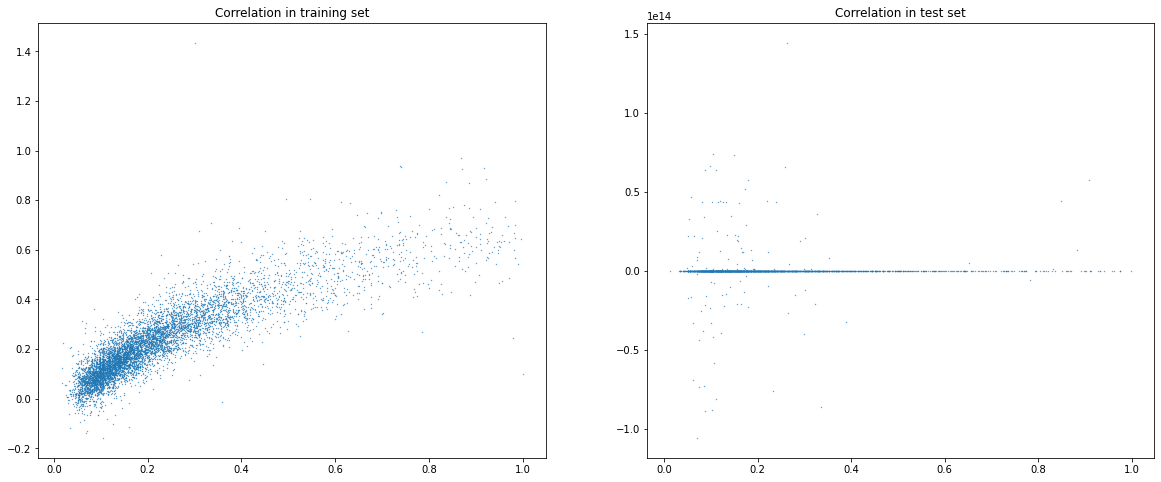

In [33]:
from sklearn.linear_model import LinearRegression

modelLM = LinearRegression()
modelLM.fit(trainXX, trainY);


plotScatterModel(trainXX, trainY, testXX, testY, modelLM)

Claramente un modelo lineal no resuelve el problema. Entonces si queremos poder interpretar el resultado vamos a tener que probar con otra cosa

# Decision Tree Regression.

**Tarea**

Una alternativa para obtener un modelo interpretable es usando árboles como modelo de regresión y preguntar por la importancia de las características. Use la clase`DecisionTreeRegressor` de `sklearn.tree`

Siguiendo el mismo esquema del modelo anterior implemente las intrucciones de la celda siguiente.

R2
{'Training': 0.7585754924381894, 'Test': 0.714347276529034}

MAPE
{'Training ': 31.95973276889779, 'Test': 32.587197492333125}


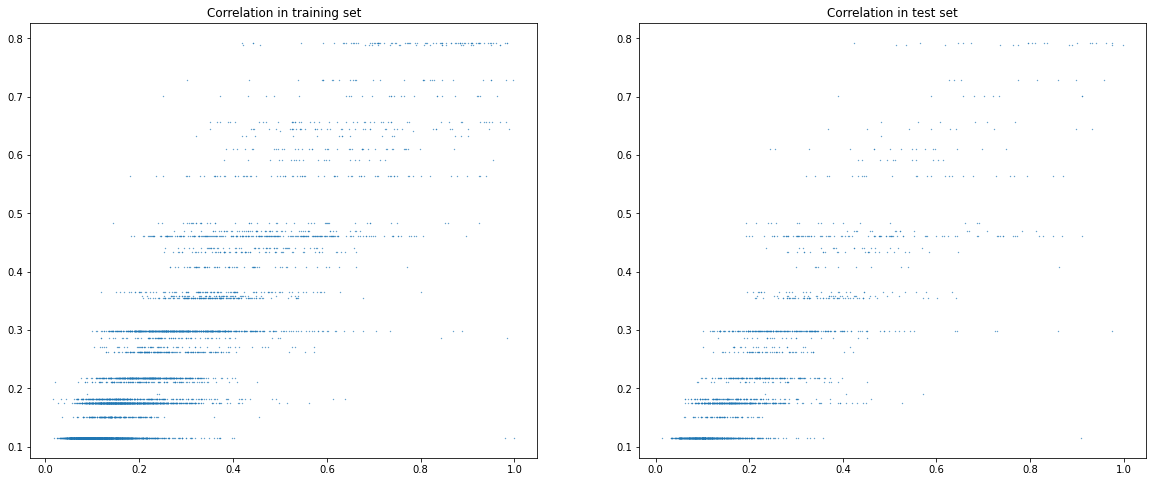

In [30]:
from sklearn.tree import DecisionTreeRegressor

#Completar
regresion = DecisionTreeRegressor(max_depth=5)
regresion.fit(trainXX, trainY)
plotScatterModel(trainXX, trainY, testXX, testY, regresion)

Con estas líneas debería poder mostrar cual es la importancia de cada uno de los atributos del conjunto de datos. 

11

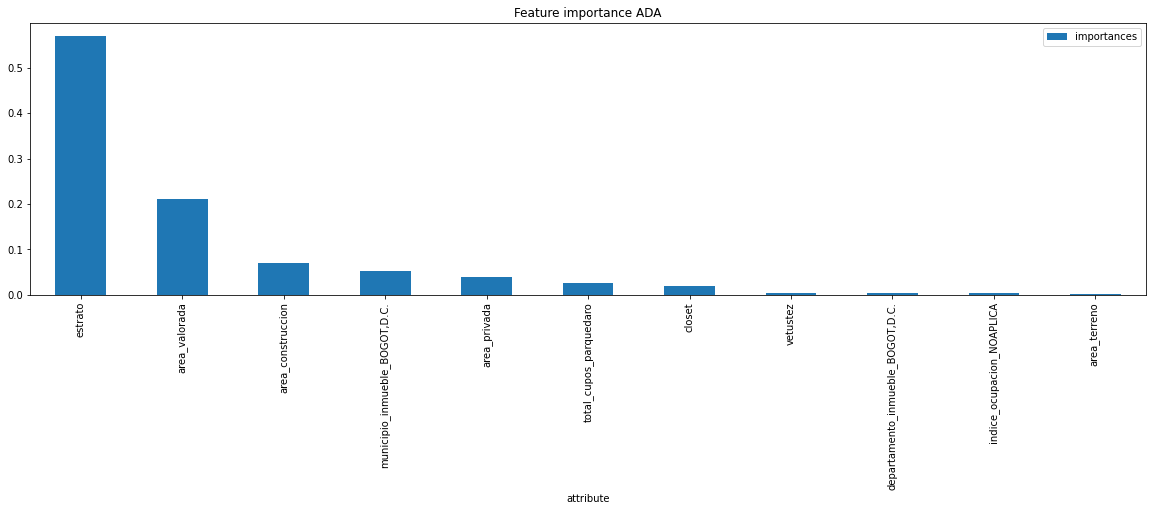

In [31]:
attributes = trainX.columns[regresion.feature_importances_> 0]
importances = regresion.feature_importances_[regresion.feature_importances_> 0]
reportOfAttributes = pd.DataFrame({'attribute': attributes, 'importances': importances})
reportOfAttributes = reportOfAttributes.sort_values(by = 'importances',  ascending=False)
reportOfAttributes = reportOfAttributes.set_index('attribute')
reportOfAttributes.plot(kind='bar', figsize=(20, 5)).set_title('Feature importance ADA')
sum(regresion.feature_importances_> 0)

# XGBOOST

**Tarea**

Ahora entrene un modelo `XGBOOST`. Use estos parámetros: 

* objective='reg:squarederror
* colsample_bytree=0.2
* learning_rate=0.1
* max_depth=5
* alpha=5
* n_estimators=200

In [ ]:
# Completar
xgb_r = xg.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.2,learning_rate=0.1,max_depth=5)

**Tarea**

Nuevamente, muestre la importancia de cada uno de los atributos según el algoritmo XGBoost

In [ ]:
# Completar

# ADABoost

Entrene un modelo ADABoost

In [ ]:
# ADABoost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


**Tarea**

Muestre la importancia de los atributos para el modelo ADABoost

In [ ]:
# Completar

# Random Forest regressor

**Tarea**

Entrene un modelo de regresión Random Forest. Use la clase `RandomForestRegressor` de `sklearn.ensemble`

In [ ]:
# RadomForest
from sklearn.ensemble import RandomForestRegressor

# Completar

**Tarea**

Muestre la importancia de los atributos para el modelo random forest.

In [ ]:
# Completar

# Red neuronal

**Tarea**

Entrene una red neuronal para este problema. Busque de manera libre los parámetros que mejor le funcionen.

In [ ]:
from sklearn.neural_network import MLPRegressor

# Completar 

#Print report
plotScatterModel(trainXX, trainY, testXX, testY, model3)

NameError: ignored

# Selección de atributos

**Tarea**

Ahora, para hacer que el modelo XGBoost se demore menos entrenando, use solo los mejores atributos del modelo ADABoost, como atributos de entrada al modelo XGBoost. 

Para esto puede seleccionar las columnas de la siguiente manera:

```py
data3 = data2.loc[:, data2.columns[modelAda.feature_importances_> 0].values]
```

In [ ]:
# Usemos los mejores atributos del modelo ADABoost para entrenar el resto de modelos de aqui en adelante
data2.shape
data3 = # Completar
data3.shape

In [ ]:

scaler = StandardScaler()  
scaler.fit(data3)
y = dataTrain[target[0]] / 1e9

# Se divide el set de datos en dos conjuntos train y test
trainX, testX, trainY, testY = train_test_split(data3, y, test_size = 0.25)

# Don't cheat - fit only on training data
trainXX = scaler.transform(trainX)  
# apply same transformation to test data
testXX = scaler.transform(testX)  

**Tarea**

Entrene un nuevo modelo XGBoost con el nuevo conjunto de datos. Compare los resultados y el tiempo requerido para el entrenamiento.

In [ ]:
xg_reg2 = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.2, learning_rate=0.1, max_depth=5, alpha=5, n_estimators=200)
xg_reg2.fit(trainXX, trainY)
plotScatterModel(trainXX, trainY, testXX, testY, xg_reg2)

# Predecir

Use el mejor modelo obtenido para predecir los precios de todas la viviendas del conjunto de `dataTest`. Guarde el resultado en un archivo 'predicciones.csv'

Para entregar, deberá poner en una carpeta este notebook, junto con el archivo de las las predicciones para el conjunto de test